In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import BehaviourFeatureExtractor, plot_mouse_angle_to_pup, convert_seconds_to_frame

## Reading and converting times ##

In [30]:
# from a datetime format string "minutes:seconds" return the number of seconds
def time_to_seconds(time):
    minutes, seconds = time.split(":")
    return int(minutes)*60 + int(seconds)

# from a value of seconds, return the corresponding minutes string minutes:string
def seconds_to_time(seconds):
    minutes = seconds // 60
    seconds = seconds % 60
    return str(int(minutes)) + ":" + str(int(seconds))

time = 382.266
print("time:", seconds_to_time(time))

actual_time = "6:27"
print("actual time:", actual_time, ", in_seconds:", time_to_seconds(actual_time))

time: 6:22
actual time: 6:27 , in_seconds: 387


## Reading and loading data ##

In [12]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file = "config.json")

Found items ['.DS_Store', 'MBI5335RR'] at directory data
Found items ['.DS_Store', 'MBI5335RR_240309_d6', 'MBI5335RR_240305_d2', 'MBI5335RR_240304_d1', 'MBI5335RR_240308_d5', 'MBI5335RR_240306_d3', 'MBI5335RR_240307_d4'] at directory data/MBI5335RR
Found items ['MBI5335RR_240309_d6_Avisoft', 'MBI5335RR_240309_d6_Behavior'] at directory data/MBI5335RR/MBI5335RR_240309_d6
Found items ['MBI5335RR_240309_d6_Avisoft_concatenated 2024-04-21  2_08 PM_Stats_SYNCCORRECTED.xlsx'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Avisoft
Found items ['MBI5335RR_d6DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.csv', 'MBI5335RR_240309_d6_BehavSummary.csv'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Behavior
Found items ['MBI5335RR_240305_d2_Behavior', 'MBI5335RR_240305_d2_Avisoft'] at directory data/MBI5335RR/MBI5335RR_240305_d2
Found items ['MBI5335RR_240305_d2_BehavSummary.csv', 'MBI5335RR_d2DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.

## Data Exploration ##

##### Day 1 trials #####

In [13]:
# get data for d1 experiment
day1_data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = "d1")

# fill out dataframes
df_summary = day1_data['Behavior']['df_summary']
df_DLC = day1_data['Behavior']['df_dlc']

In [14]:
BF = BehaviourFeatureExtractor("config.json")
df_DLC_updated, trials_dict = BF.process_DLC(df_DLC, df_summary)

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance t

## Feature Extraction ##

### BehavSummary + DLC  ###

- **BehavSummary + DLC**
    - Define behavioral windows (e.g: -2 to +2 seconds of each behavioral event)
    - Define behavioral windows pre-event (e.g: -x to 0 seconds of each behavioral event)
    - Find behavioral events (from BehavSummaries; *timing info*) in the DLC position data (*x,y info*):
        - at each behavioral event, where was the mouse and the pup located in the arena?
            - how far was the mouse from the pup?
            - what was the head direction of the mouse (towards the pup) at that point?
            - ‘approach’ trajectory: parse out trajectory of mouse towards pup and try to find a segment which is more ‘direct’/ higher speed
        - For the pre-event behavioral window of MouseFirstPickUpSecs: what is the speed of the mouse? What is the head direction of the mouse?

In [15]:
BF = BehaviourFeatureExtractor("config.json")

xmax, ymax = BF.config["arena_bounds"]["xmax"], BF.config["arena_bounds"]["ymax"]
xmin, ymin = BF.config["arena_bounds"]["xmin"], BF.config["arena_bounds"]["ymin"]

trial_1_DLC, trial_mask = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = 1)
trial_1_DLC = BF.process_trial(trial_1_DLC, trial_num = 1, interpolate_low_likelihoods = True)


----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup


Display full trial

<Axes: xlabel='pup_y'>

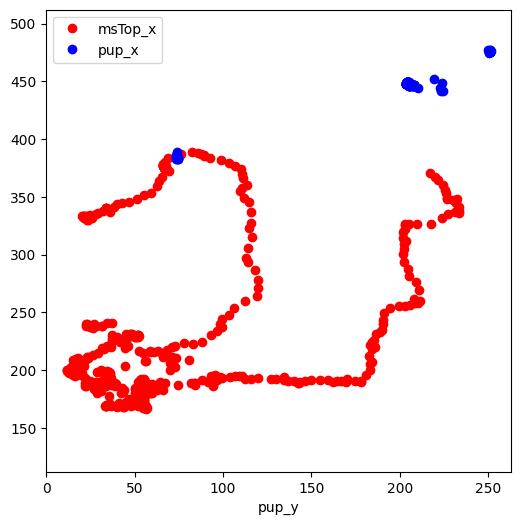

In [16]:
# plot mouse and pup positions
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

trial_1_DLC.plot(x='msTop_y', y='msTop_x', style='o', ax=ax, xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'r')
trial_1_DLC.plot(x='pup_y', y='pup_x', style='o', ax=ax,xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'b')

#### Quality Checks on low likelihood coords ####

Visualization noisy data points and comparing with nest coordinates

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup


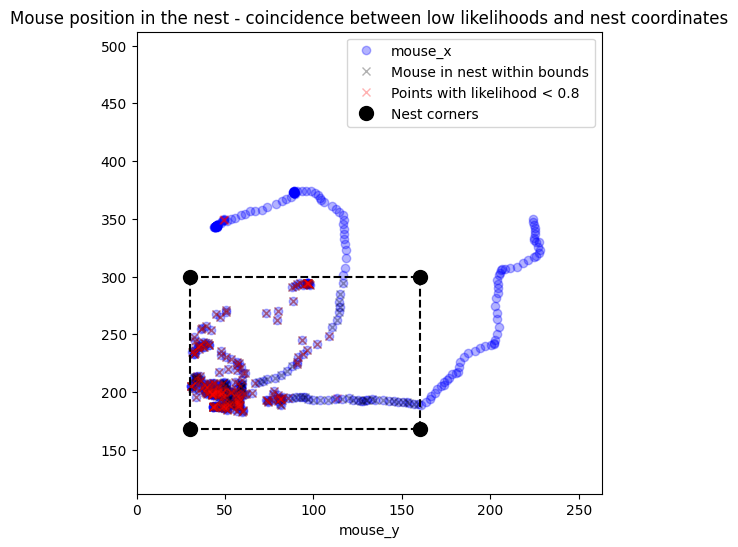

In [17]:
#### Pick trial and parameters ####
n = 1 # pick n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
threshold = 0.8
BF.likelihood_threshold = 0.8
trial_DLC, mask_trial = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = n)
trial_DLC = BF.process_trial(trial_DLC, trial_num = n, interpolate_low_likelihoods = True)
trial_DLC = trials_dict[n]

#### Retrieve masks #####
# retrieve mask of in_nest coordinates
mask_nest = (trial_DLC["in_nest"] == True)
# retrieve points with likelihood under 80
mask_low_likelihood = (trial_DLC["mouse_likelihood"] < threshold)
# plot average of center nest points
nest_avg_x, nest_avg_y = trial_DLC["centerNest_x"].mean(), trial_DLC["centerNest_y"].mean()

#### PLOT ####
# plot mouse position and highlight low likelihood points and points in the nest
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
trial_DLC.plot(x='mouse_y', y='mouse_x', style='o', ax=ax, xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'blue', alpha = 0.3)
trial_DLC[mask_nest].plot(x='mouse_y', y='mouse_x', style='x', ax=ax, xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'black', alpha = 0.3, label = f"Mouse in nest within bounds")
trial_DLC[mask_low_likelihood].plot(x='mouse_y', y='mouse_x', style='x', ax=ax, xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'r', alpha = 0.3, label = f"Points with likelihood < {threshold}")

# draw nest bounds in plot
nest_bounds = BF.config["nest_bounds"]

# plot all four nest corners and draw dashed lines between them
ax.plot(nest_bounds["ymin"], nest_bounds["xmin"], 'o', color = 'black', markersize = 10, label = "Nest corners") # bottom left corner
ax.plot(nest_bounds["ymax"], nest_bounds["xmin"], 'o', color = 'black', markersize = 10) # bottom right corner
ax.plot(nest_bounds["ymin"], nest_bounds["xmax"], 'o', color = 'black', markersize = 10) # top left corner
ax.plot(nest_bounds["ymax"], nest_bounds["xmax"], 'o', color = 'black', markersize = 10) # top right corner

# draw dashed lines between nest corners
ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmin"]], 'k--')
ax.plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmax"], nest_bounds["xmax"]], 'k--')
ax.plot([nest_bounds["ymin"], nest_bounds["ymin"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--')
ax.plot([nest_bounds["ymax"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--')

ax.set_title("Mouse position in the nest - coincidence between low likelihoods and nest coordinates") # add title

ax.legend() # plot legend

Visualizing interpolated points

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
Trial 3 started at 415.2 and ended at 494.93333333333334
Trial 3 started at 0:06:55.200000 and ended at 0:08:14.933333


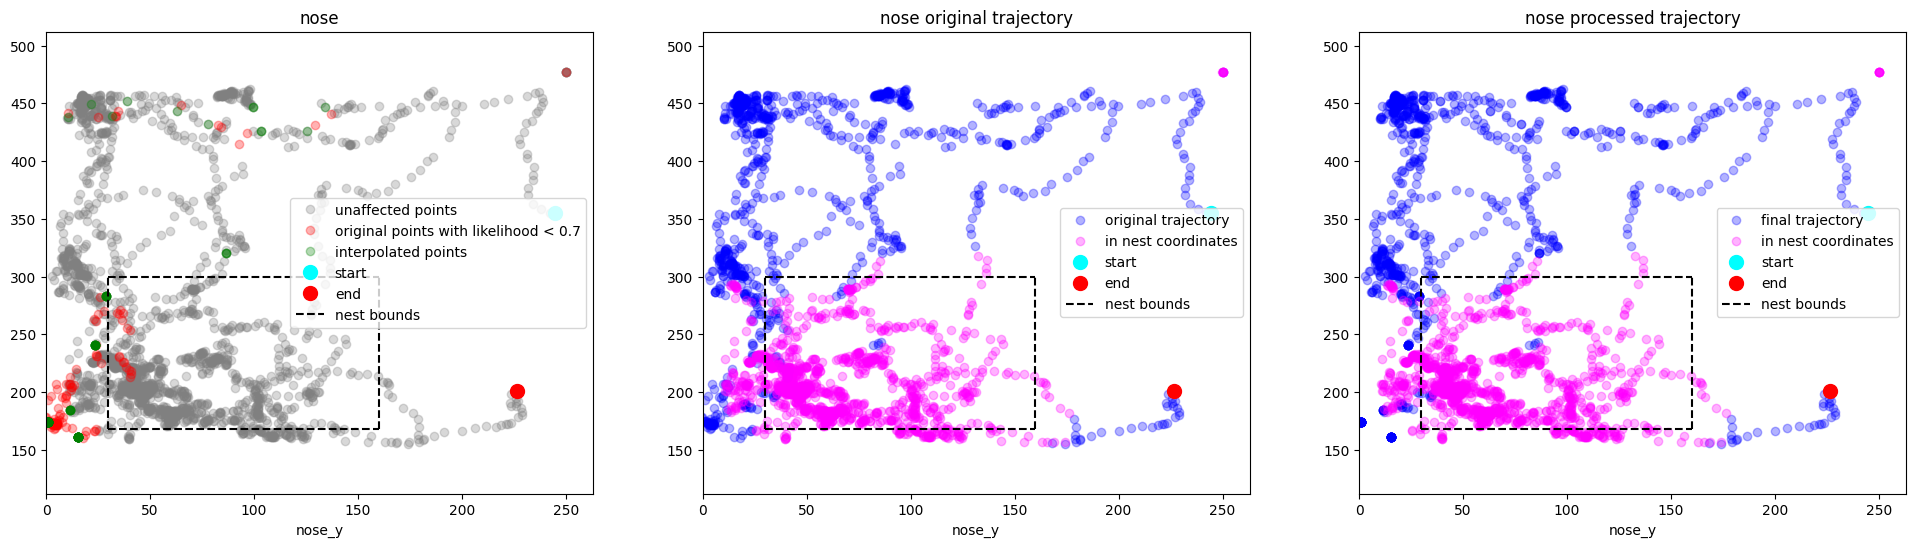

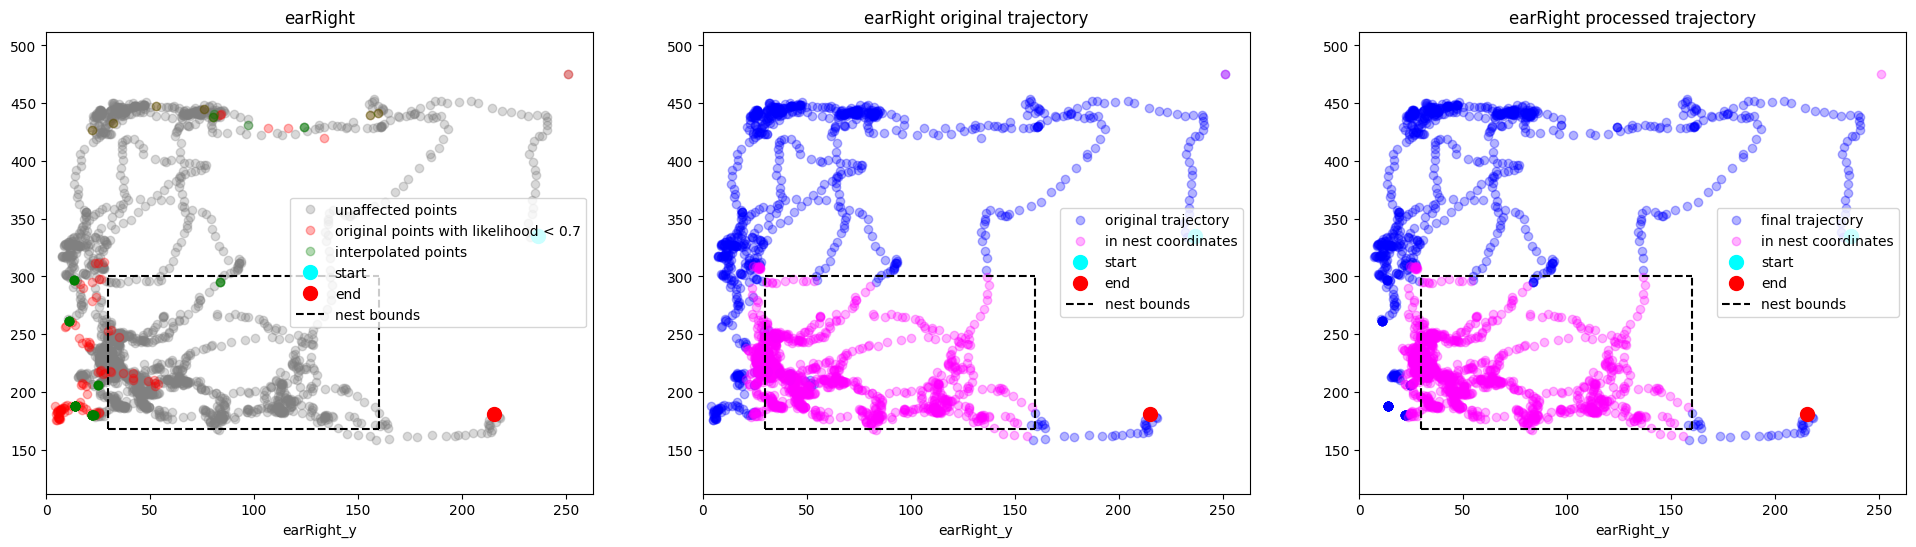

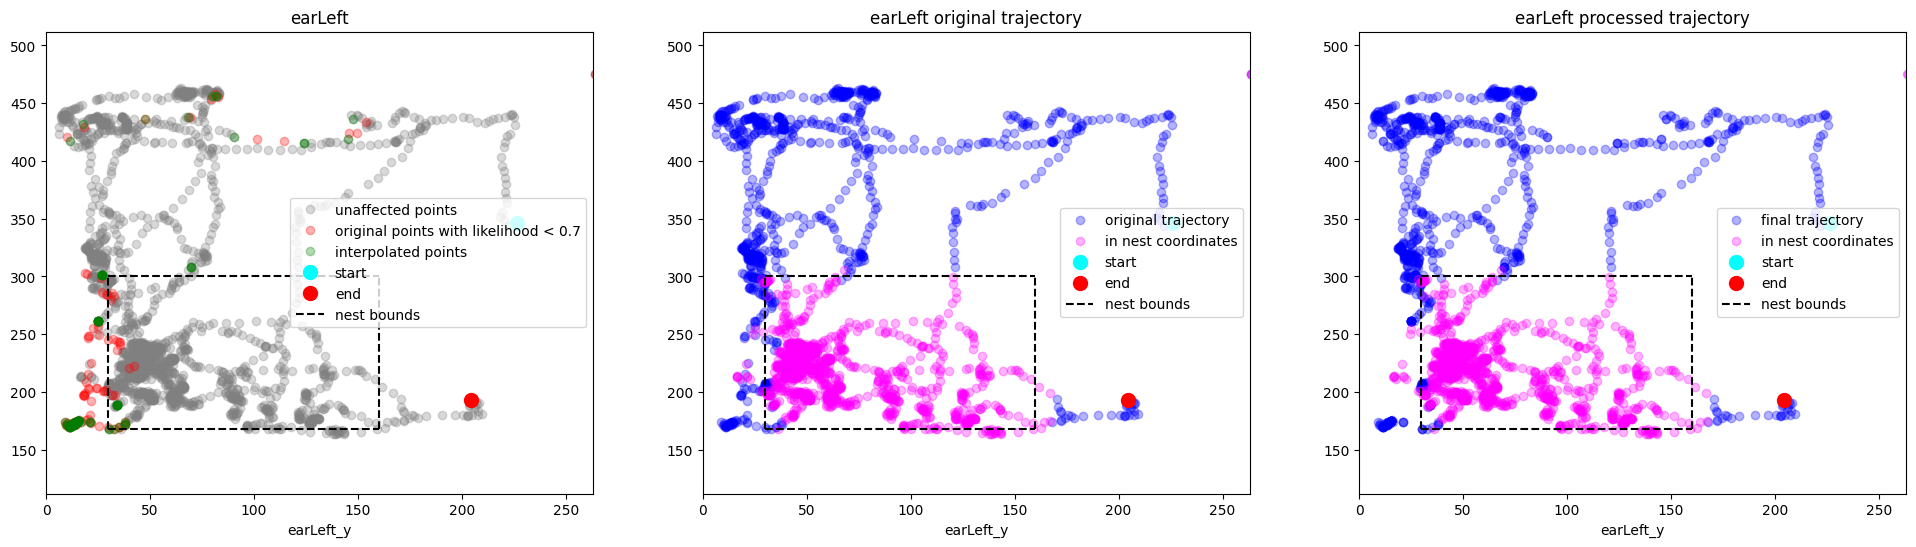

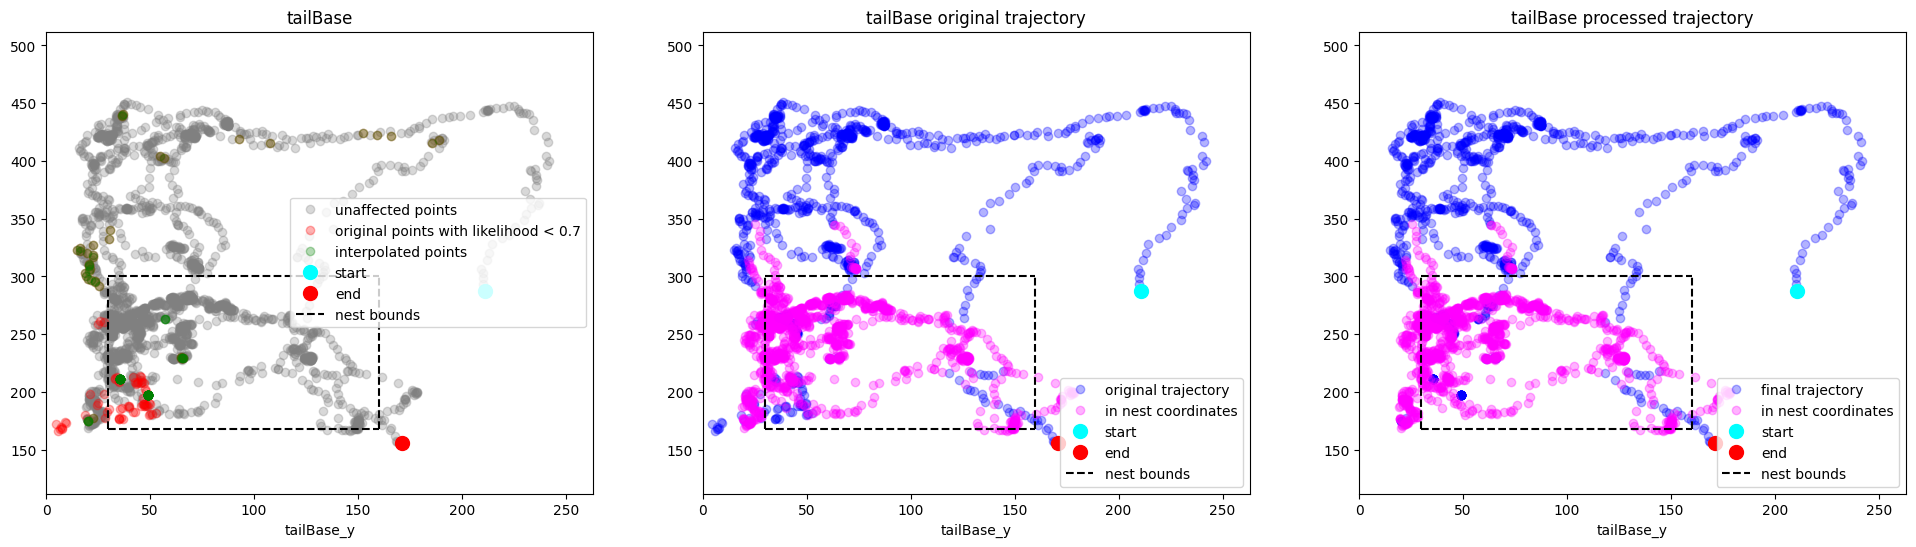

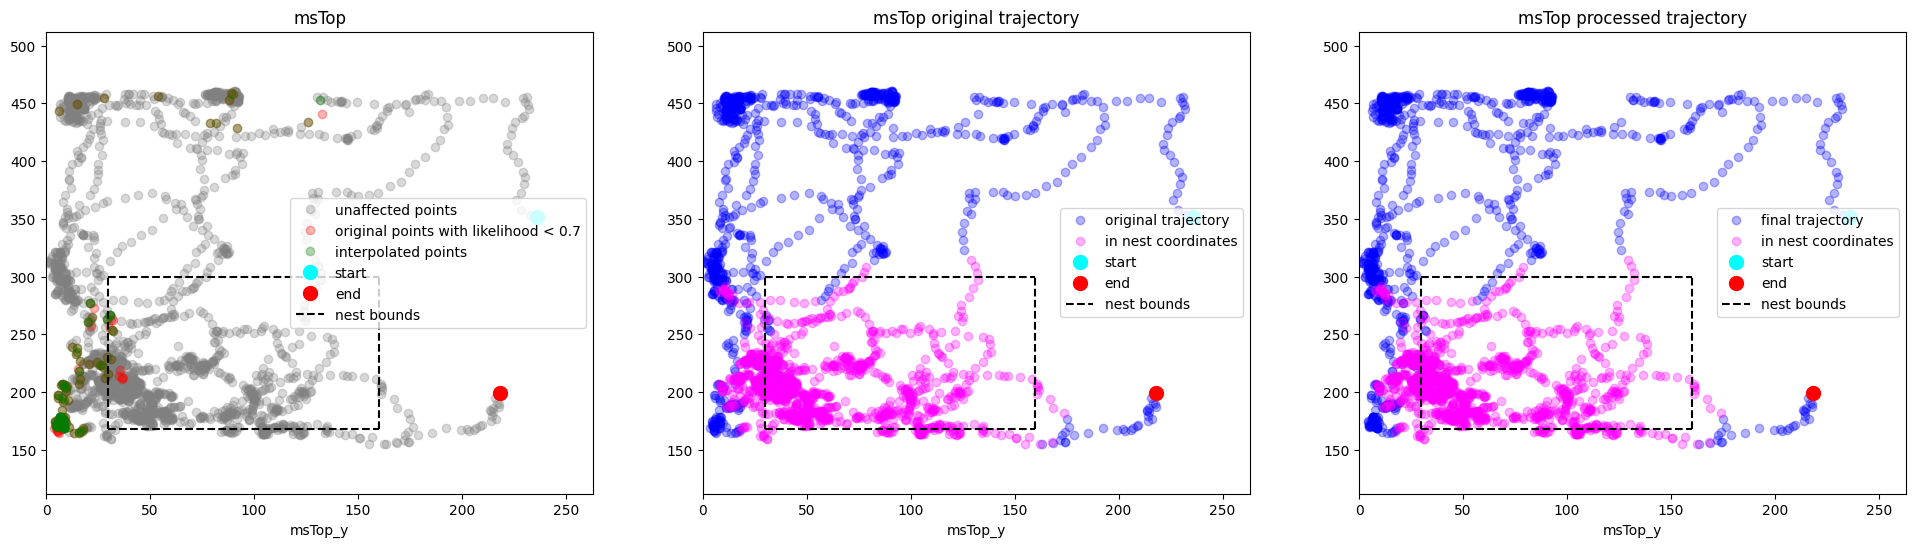

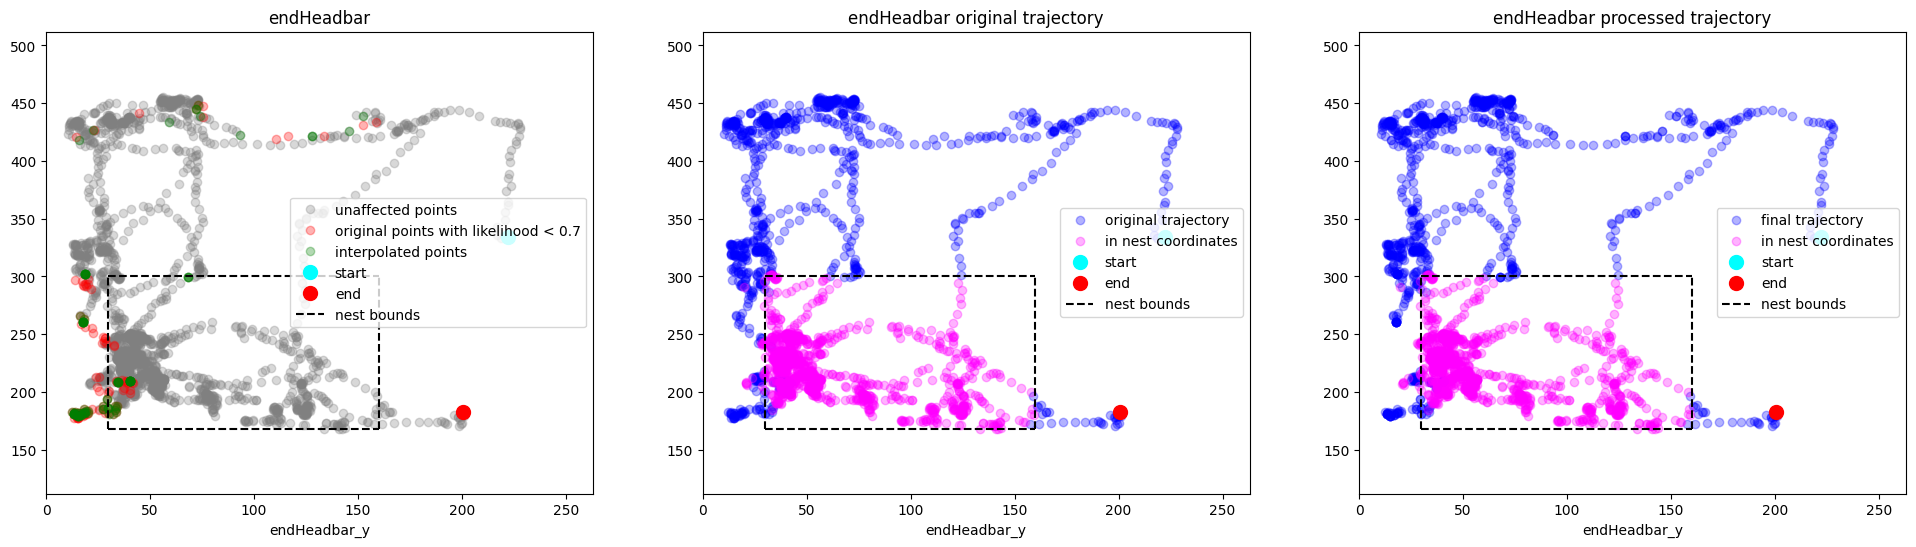

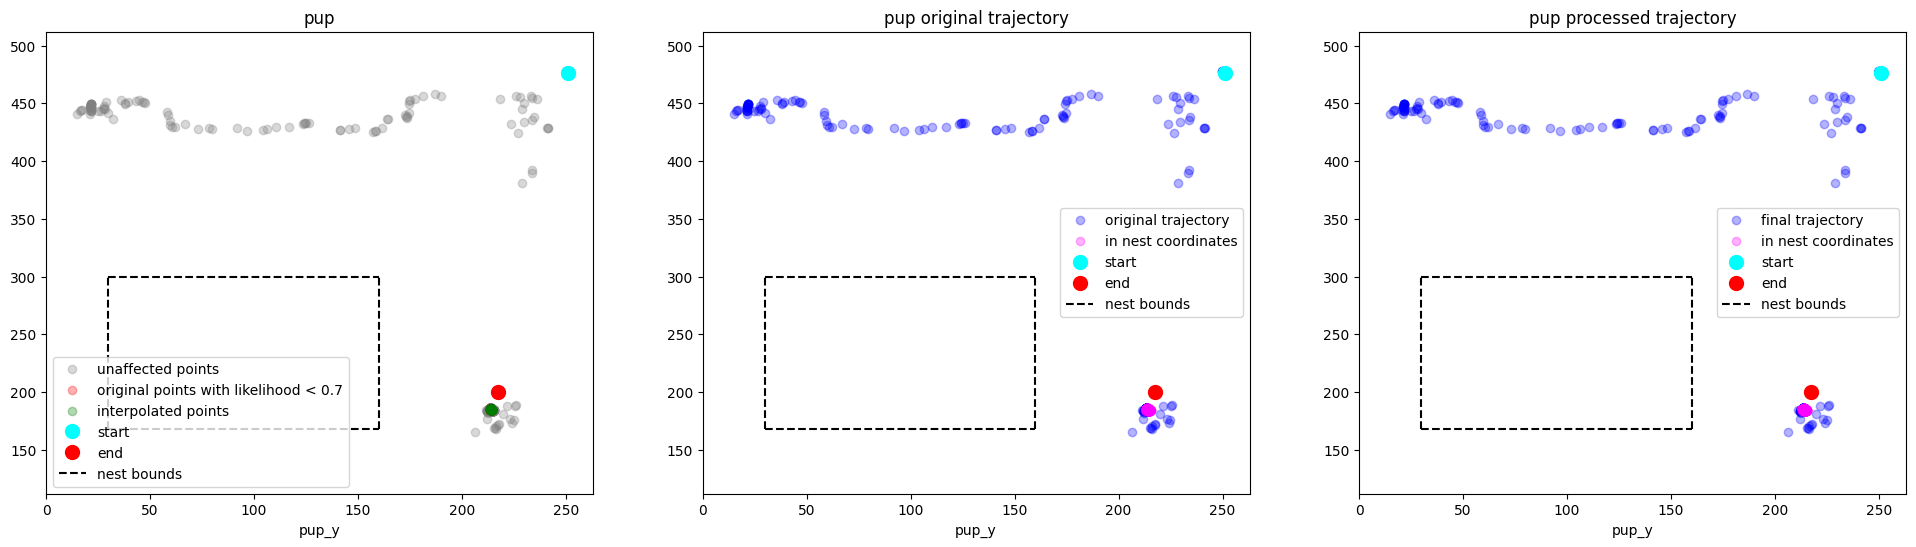

In [18]:
##### Select trial and experiment data #####
threshold = 0.7
BF.likelihood_threshold = threshold
dict_body_parts_to_coords = { k:v for k,v in BF.DLC_cols.items() if k not in ["mouse_position", "head_position", "centerNest"]}
day = "d1"
n = 3 # pick n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data = DL.get_data_for_experiment(mouse_id = "MBI5335RR", day = day)
df_DLC = data['Behavior']['df_dlc']
df_summary = data['Behavior']['df_summary']
trial_DLC, mask_trial = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = n)
trial_DLC_processed = BF.process_trial(trial_DLC, trial_num = n, interpolate_low_likelihoods = True)

mask_nest = trial_DLC_processed["in_nest"]
nest_bounds = BF.config["nest_bounds"]

###### Start and end times in minutes from the time_seconds column #####
trial_start_time = trial_DLC["time_seconds"].iloc[0]
trial_end_time = trial_DLC["time_seconds"].iloc[-1]
print(f"Trial {n} started at {trial_start_time} and ended at {trial_end_time}")
print(f"Trial {n} started at {datetime.timedelta(seconds=trial_start_time)} and ended at {datetime.timedelta(seconds=trial_end_time)}")


for body_part in dict_body_parts_to_coords.keys():

    if type(dict_body_parts_to_coords[body_part]) == dict and "likelihood" in dict_body_parts_to_coords[body_part]:
        
        mask_interpolated =(trial_DLC_processed[BF.DLC_cols["mouse_position"]["likelihood"]] < threshold) & (~mask_nest)

        # create fig
        fig, ax = plt.subplots(1, 3, figsize=(24, 6))

        ##### ---- Plot 1:
        # - visualize original points with high likelihood
        trial_DLC.loc[~mask_interpolated].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                                       style='o', ax=ax[0], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'grey', alpha = 0.3, label = "unaffected points")
        # - visualize low likelihood points in red
        trial_DLC.loc[mask_interpolated].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                                       style='o', ax=ax[0], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'red', alpha = 0.3, label = f"original points with likelihood < {threshold}")
        # - visualize interpolated points in green
        trial_DLC_processed.loc[mask_interpolated].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                                       style='o', ax=ax[0], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'green', alpha = 0.3, label = "interpolated points")
        
        #### ----- Plot 2 plot original trajectory
        trial_DLC[~mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                             style='o', ax=ax[1], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'blue', alpha = 0.3, label = "original trajectory")
        # - plot in nest coordinates
        trial_DLC[mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                           style='o', ax=ax[1], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'magenta', alpha = 0.3, label = "in nest coordinates")
        

        #### ----- Plot 3:  plot transformed/final trajectory
        trial_DLC_processed[~mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                           style='o', ax=ax[2], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'blue', alpha = 0.3, label = "final trajectory")
        # - plot in nest coordinates
        trial_DLC_processed[mask_nest].plot(x=dict_body_parts_to_coords[body_part]["y"], y=dict_body_parts_to_coords[body_part]["x"],
                                           style='o', ax=ax[2], xlim=(ymin, ymax), ylim=(xmin, xmax), color = 'magenta', alpha = 0.3, label = "in nest coordinates")
        

        # mark the first point of the trajectory as a green dot, markersize = 10, label = "start"
        ax[0].plot(trial_DLC[dict_body_parts_to_coords[body_part]["y"]].iloc[0], trial_DLC[dict_body_parts_to_coords[body_part]["x"]].iloc[0], 'o', color = 'cyan', markersize = 10, label = "start")
        ax[1].plot(trial_DLC[dict_body_parts_to_coords[body_part]["y"]].iloc[0], trial_DLC[dict_body_parts_to_coords[body_part]["x"]].iloc[0], 'o', color = 'cyan', markersize = 10, label = "start")
        ax[2].plot(trial_DLC_processed[dict_body_parts_to_coords[body_part]["y"]].iloc[0], trial_DLC_processed[dict_body_parts_to_coords[body_part]["x"]].iloc[0], 'o', color = 'cyan', markersize = 10, label = "start")

        # mark the last point of the trajectory as a red dot, markersize = 10, label = "end"
        ax[0].plot(trial_DLC[dict_body_parts_to_coords[body_part]["y"]].iloc[-1], trial_DLC[dict_body_parts_to_coords[body_part]["x"]].iloc[-1], 'o', color = 'orange', markersize = 10, label = "end")
        ax[1].plot(trial_DLC[dict_body_parts_to_coords[body_part]["y"]].iloc[-1], trial_DLC[dict_body_parts_to_coords[body_part]["x"]].iloc[-1], 'o', color = 'orange', markersize = 10, label = "end")
        ax[2].plot(trial_DLC_processed[dict_body_parts_to_coords[body_part]["y"]].iloc[-1], trial_DLC_processed[dict_body_parts_to_coords[body_part]["x"]].iloc[-1], 'o', color = 'orange', markersize = 10, label = "end")
        
        # set title of body part as title of the plot
        ax[0].set_title(body_part)
        ax[1].set_title(body_part+ " original trajectory")
        ax[2].set_title(body_part+ " processed trajectory")

        # plot legend

        for i in range(3):
            # plot nest bounds
            ax[i].plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmin"]], 'k--')
            ax[i].plot([nest_bounds["ymin"], nest_bounds["ymax"]], [nest_bounds["xmax"], nest_bounds["xmax"]], 'k--')
            ax[i].plot([nest_bounds["ymin"], nest_bounds["ymin"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--')
            ax[i].plot([nest_bounds["ymax"], nest_bounds["ymax"]], [nest_bounds["xmin"], nest_bounds["xmax"]], 'k--', label = "nest bounds")
            # plot legend
            ax[i].legend()





### Computing Base Parameters ###

In [19]:
trial_1_DLC, mask_trial = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = 3)
trial_1_DLC = BF.process_trial(trial_1_DLC, trial_num = 3, interpolate_low_likelihoods = True)
mask = (trial_1_DLC["in_nest"] == False)

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup


Speed

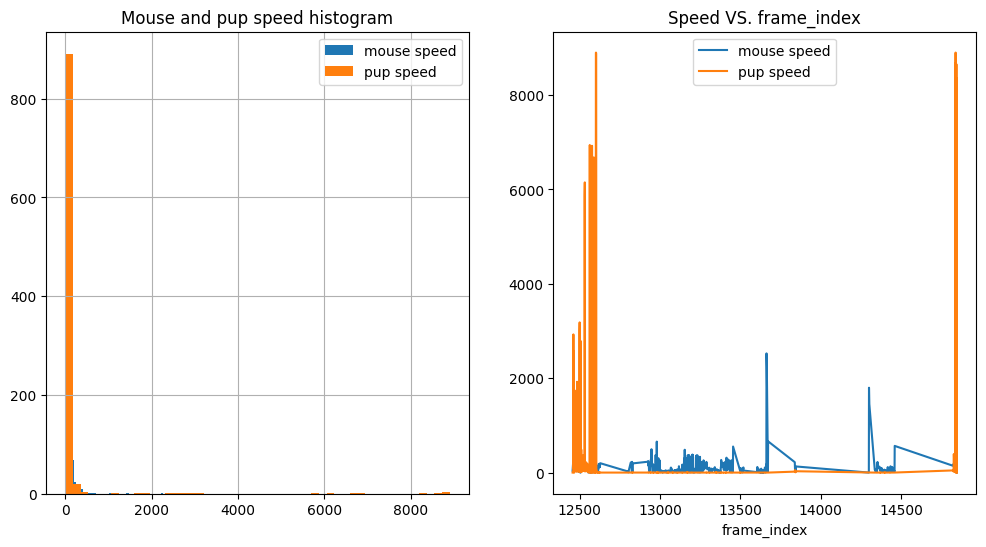

In [20]:
mouse_speed_col = BF.DLC_behaviour_cols["mouse_speed"]
pup_speed_col = BF.DLC_behaviour_cols["pup_speed"]

# create a grid of 2 histogram plots one for mouse speed and one for pup speed
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# histogram of speed

trial_1_DLC[mask][mouse_speed_col].hist(bins=50, ax=ax[0], label = 'mouse speed')
trial_1_DLC[mask][pup_speed_col].hist(bins=50, ax=ax[0], label = 'pup speed')
ax[0].set_title('Mouse and pup speed histogram')  # set title
ax[0].legend()  # show legend

# histogram of speed
trial_1_DLC[mask].plot(x='frame_index', y=mouse_speed_col, ax=ax[1], label = 'mouse speed')
trial_1_DLC[mask].plot(x='frame_index', y=pup_speed_col, ax=ax[1], label = 'pup speed')

ax[1].set_title('Speed VS. frame_index')  # set title
ax[1].legend()  # show legend

Distance to pup

Text(0.5, 0, 'Distance (px)')

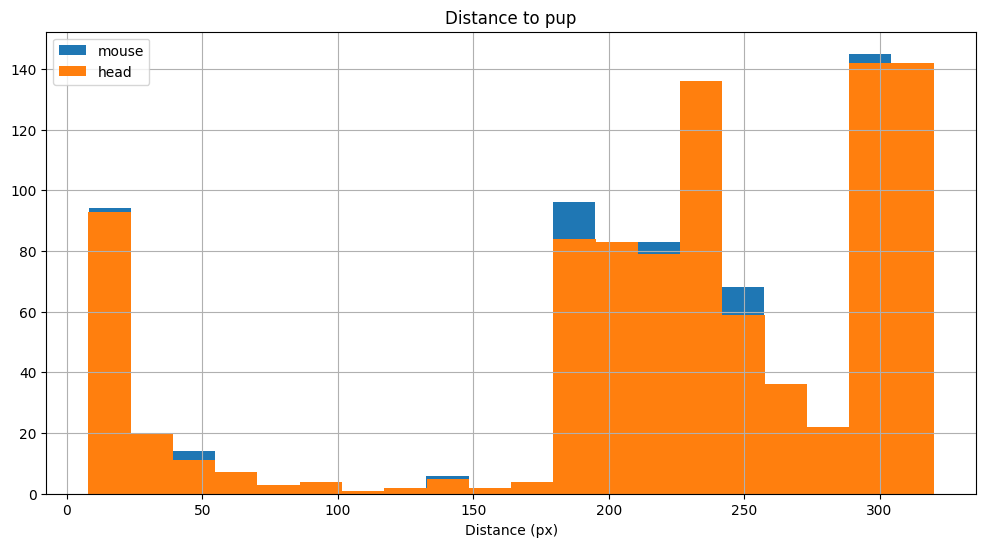

In [21]:
distance_mouse_to_pup = 'distance_mouse_to_pup'
distance_head_to_pup = 'distance_head_to_pup'
head_x_col, head_y_col = 'endHeadbar_x','endHeadbar_y'

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

trial_1_DLC[mask][distance_mouse_to_pup].hist(bins=20, ax=ax, label = 'mouse')
trial_1_DLC[mask][distance_head_to_pup].hist(bins=20, ax=ax, label = 'head')

ax.legend()

ax.set_title('Distance to pup')  # set title
ax.set_xlabel('Distance (px)')  # set x label

Head angle to pup

Text(0.5, 0, 'Angle (degrees)')

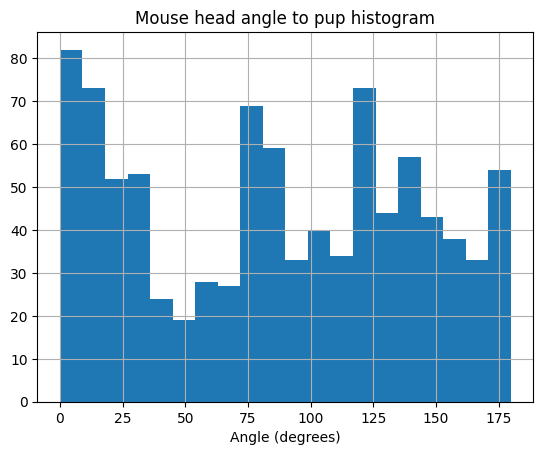

In [22]:
head_angle_to_pup_col = 'head_angle_to_pup_degrees'

trial_1_DLC[mask][head_angle_to_pup_col].hist(bins=20)
# set title
plt.title('Mouse head angle to pup histogram')
plt.xlabel('Angle (degrees)')  # set x-axis label

Visualize head angle to pup

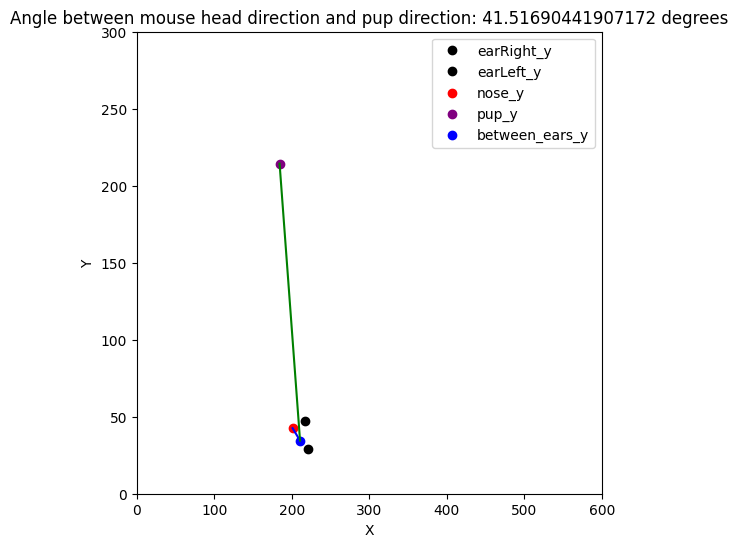

In [23]:
trial_1_DLC = BF.compute_head_angle_to_pup(trial_1_DLC, add_vector_columns=True)
plot_mouse_angle_to_pup(trial_1_DLC, ylim = 300 , xlim = 600)

#### Process full file (df_DLC) ####

In [24]:
df_DLC, df_summary = DL.get_data_for_experiment(mouse_id = "MBI5335RR", day = "d1")['Behavior'].values()

BF = BehaviourFeatureExtractor("config.json")
df_DLC_updated, trials_dict = BF.process_DLC(df_DLC, df_summary)

----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance to pup
----> Computing head angle to pup
----> Interpolating low likelihood values
----> Computing speed
----> Computing distance t

In [25]:
df_DLC_updated.head(3)

,frame_index,time_seconds,msTop_x,msTop_y,msTop_likelihood,endHeadbar_x,endHeadbar_y,endHeadbar_likelihood,earRight_x,earRight_y,...,head_x,head_y,head_likelihood,pup_speed_px/s,mouse_speed_px/s,distance_mouse_to_pup,distance_head_to_pup,head_angle_to_pup_degrees,in_nest,TrialNum
151,151,5.033333,170.865509,89.811813,0.961542,190.735977,79.387955,0.943847,174.400299,80.521759,...,185.848581,83.808566,0.907408,NaN,NaN,NaN,NaN,NaN,True,NaN
152,152,5.066667,170.884583,89.919662,0.960909,190.975998,79.499725,0.941302,174.574753,80.326324,...,185.651572,83.932812,0.905407,NaN,NaN,NaN,NaN,NaN,True,NaN
153,153,5.100000,170.883240,90.323051,0.961621,191.376846,80.730232,0.936073,174.205078,80.630722,...,185.266666,83.087607,0.895341,NaN,NaN,NaN,NaN,NaN,True,NaN


In [26]:
print("Elements of trials_dict:", trials_dict.keys())
trials_dict[1].head(3)

Elements of trials_dict: dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


,frame_index,time_seconds,msTop_x,msTop_y,msTop_likelihood,endHeadbar_x,endHeadbar_y,endHeadbar_likelihood,earRight_x,earRight_y,...,head_x,head_y,head_likelihood,pup_speed_px/s,mouse_speed_px/s,distance_mouse_to_pup,distance_head_to_pup,head_angle_to_pup_degrees,in_nest,TrialNum
11072,11072,369.066667,211.098618,66.026276,0.262119,194.405746,59.853741,0.227935,185.651154,50.854977,...,190.367307,47.329676,0.267444,2.601532,278.424087,349.082791,350.839027,177.221608,True,NaN
11073,11073,369.100000,203.101562,44.883198,0.139015,197.106476,60.143154,0.255601,202.642029,74.405647,...,196.253473,56.367642,0.264922,0.020415,258.487665,340.386672,340.862167,47.468735,True,NaN
11074,11074,369.133333,213.183609,66.150902,0.735463,200.254944,52.229858,0.362945,206.455994,69.558716,...,205.817728,59.679120,0.426715,0.004578,293.783507,332.604115,331.129988,26.092726,True,NaN


## Detecting higher level behaviours ##

Carrying

Approach

Crouching/Sniffing/Licking/Grooming

# Behavioural windows #

### Behavioural Windows (+/- 2s) around key events ###

In [27]:
def extract_feature_behavioural_window(behaviour_col, trial_num, df_DLC, df_summary, window_size = 60):

    # get the trial
    trial_metadata = df_summary[df_summary['TrialNum'] == trial_num]
    BehavRecdTrialEndSecs = trial_metadata['BehavRecdTrialEndSecs'].values[0]

    # nan check
    if np.isnan(BehavRecdTrialEndSecs):
        warnings.warn("BehavRecdTrialEndSecs is NaN")
        return None
    
    end_frame = BF.convert_seconds_to_frame(BehavRecdTrialEndSecs)
    start_frame = end_frame - window_size

    pass
    # return a slice of the dataframe with the features speed, head_angle, distance to pup, extracted

### Pre-event behavioural window (-Xs preceding key event) ###

In [28]:
def extract_feature_pre_event_window(behaviour_col, trial_num, df_DLC, df_summary, pre_event_window_size = 100):

    pass

### Analyzing parameters ###

In [29]:
def analyze_trajectory(df_DLC, start_frame, end_frame):
    
    print("Trajectory detected from frame {} to frame {}".format(start_frame, end_frame))
    